In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Additional Packages** 

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model

# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
    
import tensorflow as tf
import random

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

import tensorflow.keras.backend as K

In [11]:
import datetime

start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

# **Loading images**

In [12]:
## the number of cat individuals 
num_classes = 10

# I select 10 cat individauls who have more than 40 images 
selection = [6, 7, 15, 18, 19, 29, 55, 57, 82, 152]

## initial an empty list 'labels' to store name of cat individual for each image.
labels = []

#for i in range(1, num_classes+1): <ignore>
for i in selection:
    label = '000' + str(i)
    labels.append(label[-4:])

# initial an empty list X to store image of np.array()
X = []

# initial an empty list Z to store labels/names of cat individauls
Z = []

# standard image size, which will be sent to Neural Network
IMG_SIZE = 150

# directioary of storage of cat images
dir = '../dataset/cat_individuals_dataset/'

# function to automate store images of np.array() to X, and labels to Z 
def make_train_data(labels = labels):
    for label in labels:
        DIR = dir + label
        for img in tqdm(os.listdir(DIR)):
            path = os.path.join(DIR,img)
            # reading images
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            # resizing images to (150, 150, 3), 3 is the number of channels - RGB
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
            X.append(np.array(img))
            Z.append(str(label))

make_train_data()

100%|██████████| 41/41 [00:02<00:00, 14.92it/s]


In [13]:
## Transform labels in Z to Y from class 0 to class 9, as 10 different cat individuals
le=LabelEncoder()
Y=le.fit_transform(Z)

## Transform and normalize X in the range of [0, 1]
X=np.array(X)
X=X/255.

In [14]:
## shape of X, (number_image, image_size, image_size, channel_size)
X.shape

(480, 150, 150, 3)

# **Spliting Dataset (train_set/val_set/test_set)**

In [15]:
# separate data train:val:test = 80:10:10
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2, stratify = Y, random_state=42)
x_val,x_test,y_val,y_test=train_test_split(x_test,y_test, stratify = y_test, test_size=0.5,random_state=42)

# **SNN with contrastive loss**

## Helper functions

In [16]:
## Helper ## Function to create positive pairs and negative pairs
def create_pairs(images, labels, numClasses = num_classes):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive (0) or negative (1)
    np.random.seed(2021)
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    idx = [np.where(labels == i)[0] for i in range(numClasses)]
    
    # loop voer all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick on an image that belongs to the *same* class label
        posId = random.choice(idx[label])
        posImage = images[posId]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = np.where(labels != label)[0]
        negIdx = random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update out lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])
    
    return (np.array(pairImages), np.array(pairLabels))


# Function to calculate the distance between two images (Euclidean Distance used here)
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

# Generate pos/neg pairs for train_set, val_set
(pairTrain, labelTrain) = create_pairs(x_train, y_train)
(pairVal, labelVal) = create_pairs(x_val, y_val)

## SNN with contrastive loss structure 

In [17]:
# contrastive loss function
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss


# Base model with pre-training VGG16
def embedding_model_cl(inputShape, embeddingDim=128):
    # VGG16 as base_model
    base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                   input_shape = inputShape,
                                                   weights = 'imagenet')

    # freeze all the layers of VGG16, so they won't be trained.
    for layer in base_model.layers:
        layer.trainable = False
    
    inputs = tf.keras.layers.Input(shape=inputShape)
    #x = data_augmentation(inputs)
    x = base_model(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(units=embeddingDim)(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

# Complete model
def complete_model_cl(base_model):
    # Create the complete model with pair
    # embedding models and minimize the distance for positive pair
    # and maximum the distance for negative pair
    # between their output embeddings
    imgA = tf.keras.layers.Input(shape=((IMG_SIZE, IMG_SIZE, 3)))
    imgB = tf.keras.layers.Input(shape=((IMG_SIZE, IMG_SIZE, 3)))

    base_model = embedding_model_cl((IMG_SIZE, IMG_SIZE, 3))
    
    featsA = base_model(imgA)
    featsB = base_model(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer="adam")
    return model

# Training with contrastive loss

In [18]:
base_model_cl = embedding_model_cl((IMG_SIZE, IMG_SIZE, 3))
model_cl = complete_model_cl(base_model_cl)
model_cl.summary()

history_cl = model_cl.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:], 
                   validation_data = ([pairVal[:, 0], pairVal[:, 1]], labelVal[:]),
                   batch_size = 16, epochs=100, 
                   callbacks=[
                    TensorBoard(log_dir='./logs/cl_%s' % (start_time)),
                    ModelCheckpoint('./models/cl_%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
                    ]
  )

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 128)          16844992    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_4[0][0]              

# **SNN with triplet loss**

## Helper functions

In [19]:
def get_image(label, val=False):
    """Choose an image from our training or val data with the
    given label."""
    if val:
        y = y_val; X = x_val
    else:
        y = y_train; X = x_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]


def get_triplet(val=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(10)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(10)
    a, p = get_image(a, val), get_image(a, val)
    n = get_image(n, val)
    return a, p, n


def generate_triplets(val=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or val."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(val)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)
            
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size)
        yield [A, P, N], label

## SNN with triplet loss structure

In [20]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

def embedding_model_tl(inputShape, embeddingDim=128):
    # VGG16 as base_model
    base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                   input_shape = inputShape,
                                                   weights = 'imagenet')

    # freeze all the layers of VGG16, so they won't be trained.
    for layer in base_model.layers:
        layer.trainable = False
    
    inputs = tf.keras.layers.Input(shape=inputShape)
    #x = data_augmentation(inputs)
    x = base_model(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(units=embeddingDim)(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model


def complete_model_tl(base_model):
    # Create the complete model with three
    # embedding models and minimize the loss 
    # between their output embeddings
    input_1 = tf.keras.layers.Input((imsize, imsize, 3))
    input_2 = tf.keras.layers.Input((imsize, imsize, 3))
    input_3 = tf.keras.layers.Input((imsize, imsize, 3))
        
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)
   
    loss = tf.keras.layers.Lambda(triplet_loss)([A, P, N]) 
    model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    return model

# Training with triplet loss

In [21]:
imsize = 150
batch_size = 16
embedding_dim = 2 
LR = 0.0001
EPOCHS = 5
alpha = 0.5 

train_generator = generate_triplets()
val_generator = generate_triplets(val=True)
batch = next(train_generator)

base_model_tl = embedding_model_tl((imsize, imsize, 3))
model_tl = complete_model_tl(base_model_tl)
model_tl.summary()

history_tl = model_tl.fit_generator(train_generator, 
                                    validation_data=val_generator, 
                                    epochs=100, 
                                    verbose=1,steps_per_epoch=20, 
                                    validation_steps=30, callbacks=[
                                        TensorBoard(log_dir='./logs/tl_%s' % (start_time)),
                                        ModelCheckpoint('./models/tl_%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
                                        ]
                                        )

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 128)          16844992    input_15[0][0]                   
                                                                 input_16[0][0]             

## Plot of accuacy and loss over epoch

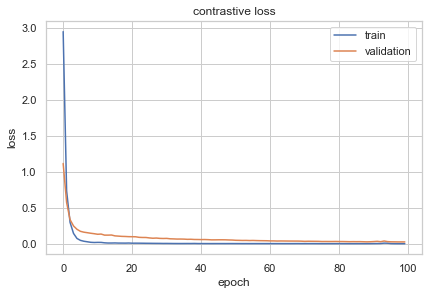

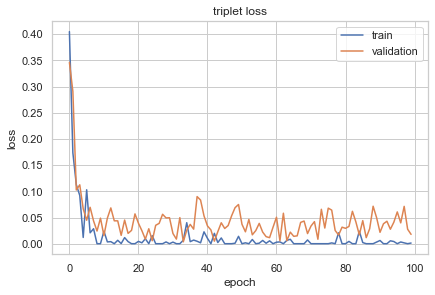

In [22]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper right")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

# Plot the constrastive loss
plt_metric(history=history_cl.history, metric="loss", title="contrastive loss")

# Plot the triplet loss
plt_metric(history=history_tl.history, metric="loss", title="triplet loss")

# Evaluating both models our test_set

In [23]:
anchor_images = [x_train[y_train==i][0] for i in range(10)]
anchor_images = np.array(anchor_images)

def evluate_acc(x_test=x_test, y_test=y_test, anchors=anchor_images, model = 'cl'):
    # model = 'cl' - contrastive loss
    # model = 'tl' - triplet loss
    pred = []
    for i in range(len(y_test)):
        dists = []
        imgA = x_test[i].reshape(1, 150, 150, 3)
        if model == 'cl':
            for j in range(len(anchors)):
                imgB = anchors[j].reshape(1, 150, 150, 3)
                dist = model_cl.predict([imgA, imgB])[0][0]
                dists.append(dist)
            dists = np.array(dists)
            idx = np.argmin(dists)
            pred.append(idx)
        elif model == 'tl':
            featsA = base_model_tl(x_test[i].reshape(1, 150, 150, 3))
            for j in range(len(anchors)):
                imgB = anchors[j].reshape(1, 150, 150, 3)
                featsB = base_model_tl(anchors[j].reshape(1, 150, 150, 3))
                dist = np.linalg.norm(featsA - featsB, 2)
                dists.append(dist)
            dists = np.array(dists)
            idx = np.argmin(dists)
            pred.append(idx)
    pred=np.array(pred)
    accuracy = np.sum(y_test == pred) / len(y_test)
    return accuracy

In [24]:
acc_cl = evluate_acc(model = 'cl')
print('The accuracy of contrastive loss on test set is {}%'.format(round(acc_cl * 100)))

acc_tl = evluate_acc(model = 'tl')
print('The accuracy of triplet loss on test set is {}%'.format(round(acc_tl * 100)))

The accuracy of contrastive loss on test set is 98%
The accuracy of triplet loss on test set is 85%


# Visualizing the distance on pairs

# Existing cat individual with anchor images

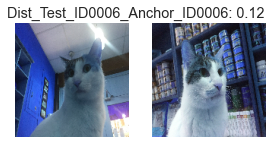

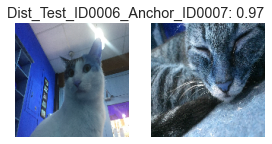

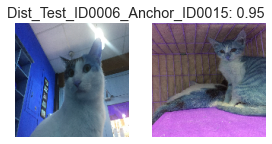

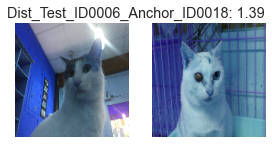

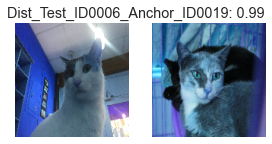

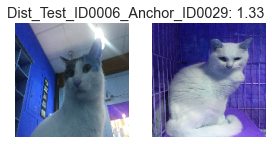

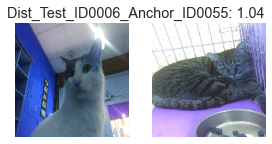

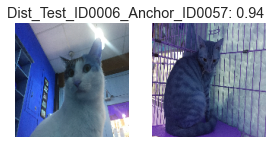

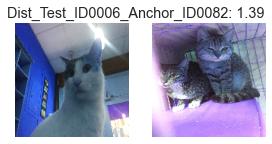

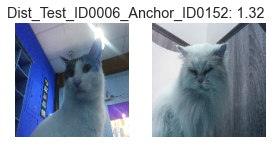

In [25]:
for i in range(len(anchor_images)):
    test = x_test[y_test==0][0].reshape(1, 150, 150, 3)
    anchor = anchor_images[i].reshape(1, 150, 150, 3)
    dist = model_cl.predict([test, anchor])[0][0]
    
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2)) 
    plt.suptitle("Dist_Test_ID0006_Anchor_ID{}: {:.2f}".format(labels[i], dist))
    
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(test[0])
    plt.axis("off")
    
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(anchor[0])
    plt.axis("off")
    
    plt.show()

## Compare unknown cat individual with anchor images

In [26]:
label = '0004'
num_lab = '002'
unknown = cv2.imread('../dataset/cat_individuals_dataset/'+ label + '/' + label + '_' + num_lab + '.JPG')
unknown = cv2.resize(unknown, (IMG_SIZE,IMG_SIZE))
unknown = unknown/255.
unknown = unknown.reshape(1, 150, 150, 3)

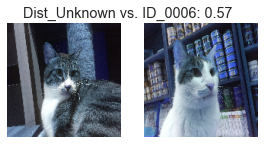

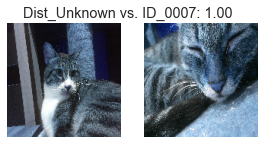

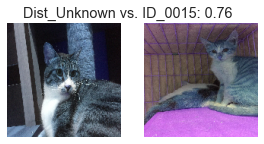

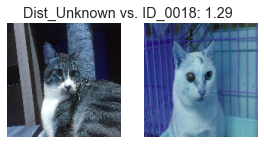

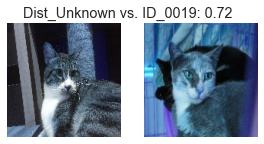

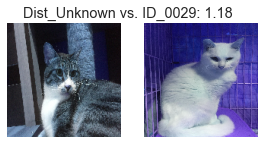

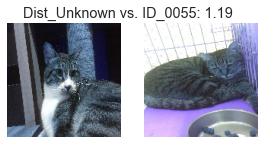

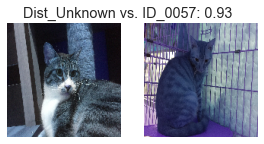

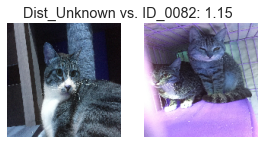

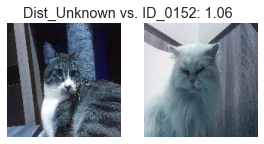

In [27]:
for i in range(len(anchor_images)):
    test = unknown.reshape(1, 150, 150, 3)
    anchor = anchor_images[i].reshape(1, 150, 150, 3)
    dist = model_cl.predict([test, anchor])[0][0]
    
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2)) 
    plt.suptitle("Dist_Unknown vs. ID_{}: {:.2f}".format(labels[i], dist))
    
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(test[0])
    plt.axis("off")
    
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(anchor[0])
    plt.axis("off")
    
    plt.show()

In [28]:
anchor_images = [x_train[y_train==i][0] for i in range(10)]
anchor_images = np.array(anchor_images)

def re_id(test_img, anchors = anchor_images, dist_threshold=0.4):
    dists = []
    for i in range(len(anchors)):
        anchor = anchors[i].reshape(1, 150, 150, 3)
        dist = model_cl.predict([test_img, anchor])[0][0]
        dists.append(dist)
    dists = np.array(dists)
    if np.sum(dists <= dist_threshold) >= 1:
        idx = np.argmin(dists)
        print('This is cat ID:{}'.format(labels[idx]))
        plt.imshow(test_img[0])
        plt.show()
    else:
        print('This cat is unknown!')
        plt.imshow(test_img[0])
        plt.show()
    

## **Example - existing cat individual in training set**

The true label of this cat individual is ID: 0029
This is cat ID:0029


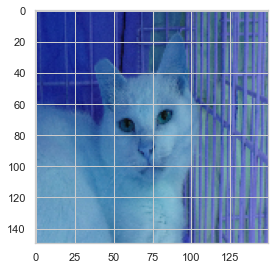

In [42]:
labels_idx = 5
print('The true label of this cat individual is ID: {}'.format(labels[labels_idx]))
test_img = x_test[y_test==labels_idx][0].reshape(1, 150, 150, 3)
re_id(test_img, dist_threshold=0.4)

# **Example - not existing cat individual in training set**

This is cat ID:0018


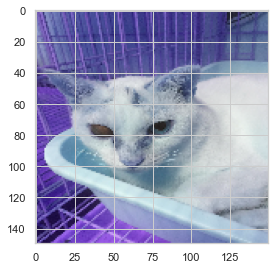

In [30]:
label = '0018'
num_lab = '002'
unknown = cv2.imread('../dataset/cat_individuals_dataset/'+ label + '/' + label + '_' + num_lab + '.JPG')
unknown = cv2.resize(unknown, (IMG_SIZE,IMG_SIZE))
unknown = unknown/255.
unknown = unknown.reshape(1, 150, 150, 3)
re_id(unknown, dist_threshold=0.4)

Save Models

In [31]:
import time

save_time = time.strftime('%y%m%d_%I%M%S', time.localtime())



In [32]:
model_cl.save("../models/cat_indivisual/cat_indivisual_model_cl_%s" %save_time)
model_cl.save_weights("../models/cat_indivisual/cat_indivisual_model_cl_weights_%s.h5" %save_time)
model_tl.save("../models/cat_indivisual/cat_indivisual_model_tl_%s" %save_time)
model_tl.save_weights("../models/cat_indivisual/cat_indivisual_model_tl_weights_%s.h5" %save_time)

INFO:tensorflow:Assets written to: ../models/cat_indivisual/cat_indivisual_model_cl_211203_035948\assets
INFO:tensorflow:Assets written to: ../models/cat_indivisual/cat_indivisual_model_tl_211203_035948\assets


In [33]:
import platform
print(platform.python_version())

tf.__version__

3.6.8


'2.6.2'

Import model weight

In [34]:
from tensorflow.keras import models

loaded_base_model = embedding_model_cl((IMG_SIZE, IMG_SIZE, 3))
loaded_model = complete_model_cl(loaded_base_model)
loaded_model.load_weights("../models/cat_indivisual/cat_indivisual_model_cl_weights_%s.h5" %save_time)

In [35]:
def loaded_re_id(test_img, anchors = anchor_images, dist_threshold=0.4):
    dists = []
    for i in range(len(anchors)):
        anchor = anchors[i].reshape(1, 150, 150, 3)
        dist = loaded_model.predict([test_img, anchor])[0][0]
        dists.append(dist)
    dists = np.array(dists)
    if np.sum(dists <= dist_threshold) >= 1:
        idx = np.argmin(dists)
        print('This is cat ID:{}'.format(labels[idx]))
        plt.imshow(test_img[0])
        plt.show()
    else:
        print('This cat is unknown!')
        plt.imshow(test_img[0])
        plt.show()

This is cat ID:0018


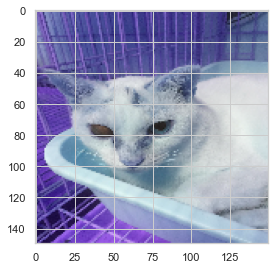

In [36]:
label = '0018'
num_lab = '002'
unknown = cv2.imread('../dataset/cat_individuals_dataset/'+ label + '/' + label + '_' + num_lab + '.JPG')
unknown = cv2.resize(unknown, (IMG_SIZE,IMG_SIZE))
unknown = unknown/255.
unknown = unknown.reshape(1, 150, 150, 3)
loaded_re_id(unknown, dist_threshold=0.4)

In [43]:
def plotArchor():
    fig = plt.figure()
    rows = 4
    cols = 4

    for i, anchor in enumerate(anchor_images):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(anchor.reshape(1, 150, 150, 3)[0])
        ax.set_xlabel(labels[i])
        ax.set_xticks([]), ax.set_yticks([])

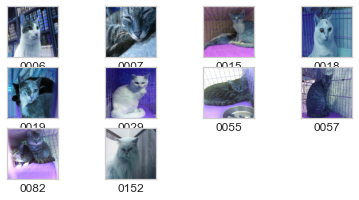

In [44]:
plotArchor()